In [4]:
import ehrapy as ep
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tableone import TableOne

import warnings

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns

from fairlearn.metrics import MetricFrame, false_negative_rate, selection_rate
from fairlearn.postprocessing import ThresholdOptimizer

In [5]:
# cohorttracker color palette
colors = sns.color_palette("colorblind", n_colors=14)

In [6]:
adata_algo = ep.dt.diabetes_130_fairlearn(
    columns_obs_only=[
        "race",
        "gender",
        "age",
        "readmitted",
        "readmit_binary",
        "discharge_disposition_id",
    ]
)
adata_algo.obs["readmit_30_days"] = adata_algo.obs["readmitted"] == "<30"

In [7]:
TableOne(adata_algo.obs, columns=["race", "gender", "age"])

Missing       Overall
n                                                  101766
race, n (%)   AfricanAmerican             0  19210 (18.9)
              Asian                             641 (0.6)
              Caucasian                      76099 (74.8)
              Hispanic                         2037 (2.0)
              Other                            1506 (1.5)
              Unknown                          2273 (2.2)
gender, n (%) Female                      0  54708 (53.8)
              Male                           47055 (46.2)
              Unknown/Invalid                     3 (0.0)
age, n (%)    '30 years or younger'       0    2509 (2.5)
              '30-60 years'                  30716 (30.2)
              'Over 60 years'                68541 (67.4)

In [8]:
# aggregate small groups
adata_algo.obs["race_all"] = adata_algo.obs["race"]
adata_algo.obs["race"] = adata_algo.obs["race"].replace(
    {"Asian": "Other", "Hispanic": "Other"}
)

# drop gender group Unknown/Invalid
adata_algo = adata_algo[adata_algo.obs["gender"] != "Unknown/Invalid", :].copy()
ep.ad.move_to_x(adata_algo, "gender")

AnnData object with n_obs × n_vars = 101763 × 19
    obs: 'race', 'age', 'readmitted', 'readmit_binary', 'discharge_disposition_id', 'readmit_30_days', 'race_all'
    var: 'ehrapy_column_type'

In [9]:
adata_algo = ep.pp.encode(
    adata_algo,
    autodetect=True,
)

Output()

In [10]:
train_idxs, test_idxs = train_test_split(
    np.arange(adata_algo.n_obs),
    stratify=adata_algo.obs["race"],
    test_size=0.5,
    random_state=0,
)
adata_algo_train = adata_algo[train_idxs, :]
adata_algo_test = adata_algo[test_idxs, :]

In [11]:
adata_algo_train_balanced = ep.pp.balanced_sample(
    adata_algo_train,
    key="readmit_30_days",
    method="RandomUnderSampler",
    random_state=0,
    copy=True,
)
adata_algo_train_balanced.obs["readmit_30_days"].value_counts()

readmit_30_days
False    5667
True     5667
Name: count, dtype: int64

In [12]:
unmitigated_pipeline = Pipeline(
    steps=[
        ("preprocessing", StandardScaler()),
        ("logistic_regression", LogisticRegression(max_iter=1000)),
    ]
)

In [13]:
unmitigated_pipeline.fit(
    adata_algo_train_balanced.X,
    adata_algo_train_balanced.obs["readmit_30_days"].astype(bool),
)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('logistic_regression', LogisticRegression(max_iter=1000))])

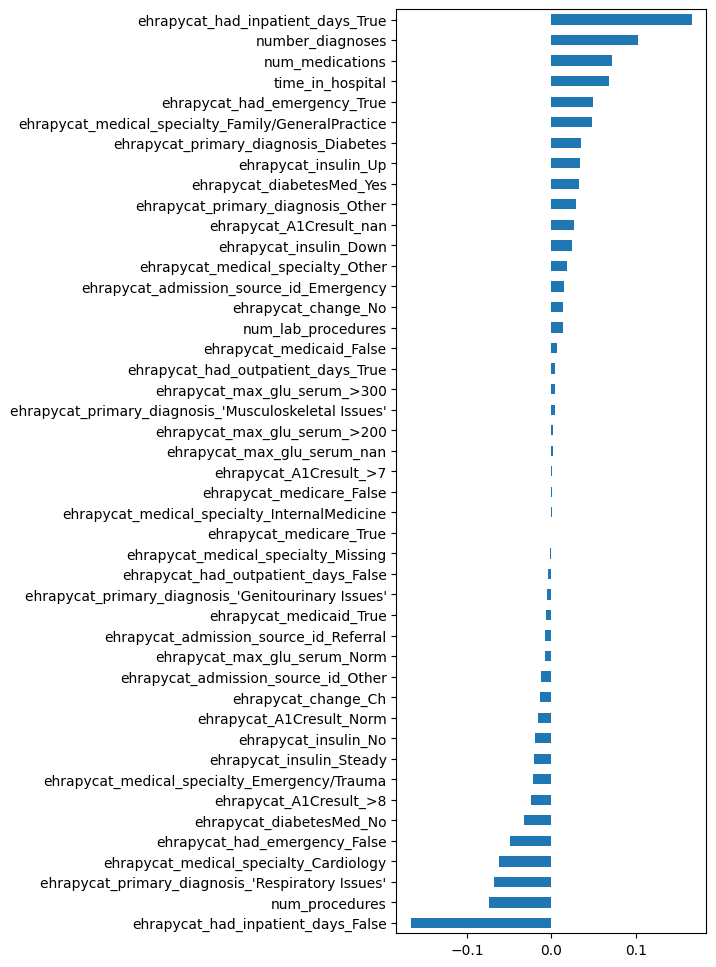

In [14]:
coef_series = pd.Series(
    data=unmitigated_pipeline.named_steps["logistic_regression"].coef_[0],
    index=adata_algo_train_balanced.var_names,
)
coef_series.sort_values().plot.barh(figsize=(4, 12), legend=False);

In [15]:
Y_pred_proba = unmitigated_pipeline.predict_proba(adata_algo_test.X)[:, 1]
Y_pred = unmitigated_pipeline.predict(adata_algo_test.X)


In [16]:
balanced_accuracy_score(adata_algo_test.obs["readmit_30_days"].astype(bool), Y_pred.astype(bool))

In [17]:
metrics_dict = {
    "selection_rate": selection_rate,
    "false_negative_rate": false_negative_rate,
    "balanced_accuracy": balanced_accuracy_score,
}

mf1 = MetricFrame(
    metrics=metrics_dict,
    y_true=adata_algo_test.obs["readmit_30_days"],
    y_pred=Y_pred,
    sensitive_features=adata_algo_test.obs["race"],
)

mf1.by_group

,selection_rate,false_negative_rate,balanced_accuracy
race,,,
AfricanAmerican,0.400833,0.419385,0.601196
Caucasian,0.382129,0.461288,0.588269
Other,0.321224,0.483568,0.608668
Unknown,0.231718,0.611650,0.586132


In [18]:
df_long = pd.melt(mf1.by_group.reset_index(), id_vars=['race'], var_name='metric', value_name='value')

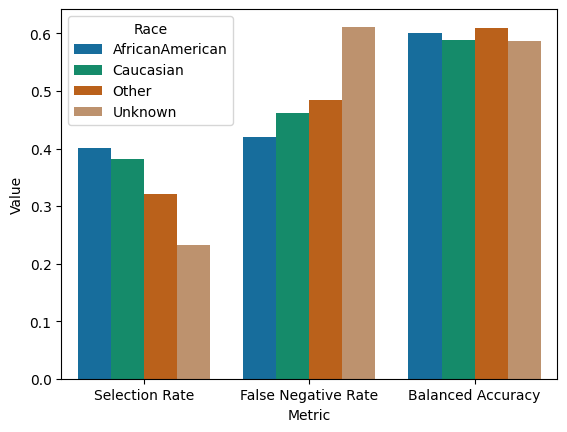

In [20]:
# colors from cohorttracker where groups are available
palette = [colors[0], colors[2], colors[3], colors[5]]

fig, ax = plt.subplots()
bar = sns.barplot(data=df_long, x="metric", y="value", hue="race", palette = palette)
ax.legend(title="Race")
ax.set_ylabel("Value")
ax.set_xlabel("Metric")
ax.set_xticklabels(labels=["Selection Rate", "False Negative Rate", "Balanced Accuracy"])
plt.savefig("algorithmic_bias_1.png", dpi=300, bbox_inches="tight")

In [22]:
# mf1.by_group.plot.bar(
#     subplots=True, layout=[1, 3], figsize=(12, 4), legend=False, rot=-45, position=1.5
# )

In [24]:
postprocess_est = ThresholdOptimizer(
    estimator=unmitigated_pipeline,
    constraints="false_negative_rate_parity",
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method="predict_proba",
)
postprocess_est.fit(
    adata_algo_train_balanced.X, adata_algo_train_balanced.obs["readmit_30_days"], sensitive_features=adata_algo_train_balanced.obs["race"]
)
Y_pred_postprocess = postprocess_est.predict(adata_algo_test.X, sensitive_features=adata_algo_test.obs["race"])
metricframe_postprocess = MetricFrame(
    metrics=metrics_dict,
    y_true=adata_algo_test.obs["readmit_30_days"],
    y_pred=Y_pred_postprocess,
    sensitive_features=adata_algo_test.obs["race"],
)
pd.concat(
    [mf1.by_group, metricframe_postprocess.by_group],
    keys=["Unmitigated", "ThresholdOptimizer"],
    axis=1,
)

Unmitigated                                        \
                selection_rate false_negative_rate balanced_accuracy   
race                                                                   
AfricanAmerican       0.400833            0.419385          0.601196   
Caucasian             0.382129            0.461288          0.588269   
Other                 0.321224            0.483568          0.608668   
Unknown               0.231718            0.611650          0.586132   

                ThresholdOptimizer                                        
                    selection_rate false_negative_rate balanced_accuracy  
race                                                                      
AfricanAmerican           0.374492            0.448276          0.599760  
Caucasian                 0.399133            0.444315          0.588252  
Other                     0.382887            0.417840          0.610931  
Unknown                   0.429956            0.446602          0.567881

In [25]:
Y_pred_mitig = postprocess_est.predict(adata_algo_test.X, sensitive_features=adata_algo_test.obs["race"])
balanced_accuracy_score(adata_algo_test.obs["readmit_30_days"].astype(bool), Y_pred_mitig.astype(bool))

In [26]:
df_long_postprocess = pd.melt(metricframe_postprocess.by_group.reset_index(), id_vars=['race'], var_name='metric', value_name='value')

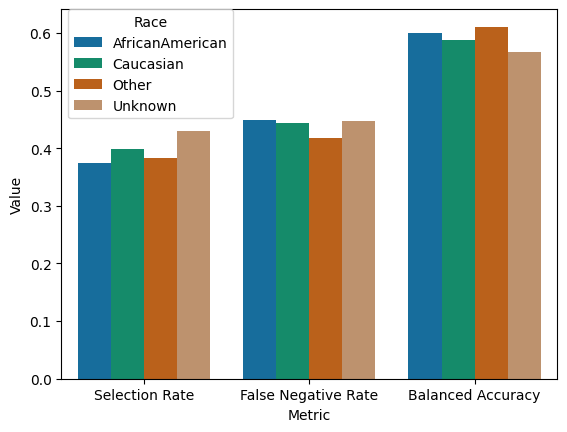

In [61]:
palette = [colors[0], colors[2], colors[3], colors[5]]

fig, ax = plt.subplots()
bar = sns.barplot(data=df_long_postprocess, x="metric", y="value", hue="race", palette=palette)
ax.legend(title="Race", loc="upper left", bbox_to_anchor=(0, 1.018))
ax.set_ylabel("Value")
ax.set_xlabel("Metric")
ax.set_xticklabels(labels=["Selection Rate", "False Negative Rate", "Balanced Accuracy"])

max_heights = df_long_postprocess.groupby("metric")["value"].max()

# for i, metric in enumerate(df_long_postprocess["metric"].unique()):
#     height = max_heights[metric]
#     x = i + bar.patches[0].get_width() / 2 - 0.1
#     ax.annotate('', (x, height+0.01), xytext=(0, 1), textcoords='offset points',
#                 arrowprops=dict(facecolor='black', shrink=0.05))


plt.savefig("algorithmic_bias_2.png", dpi=300, bbox_inches="tight")

In [45]:
ax.annotate('Arrow', xy=(0,1), xytext=(1,1),
             arrowprops=dict(facecolor='black', shrink=0.05))

Text(1, 1, 'Arrow')

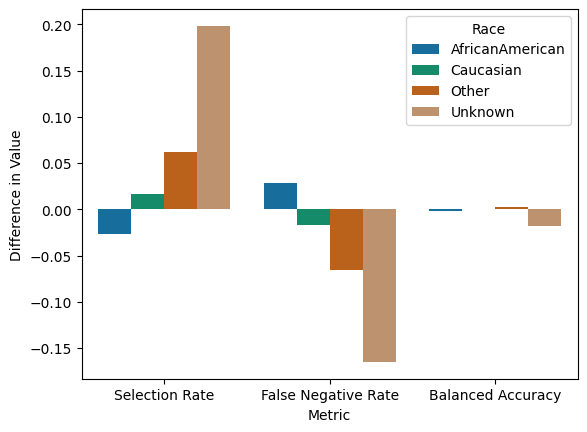

In [36]:
# Assuming df_long has the same structure as df_long_postprocess
df_diff = df_long_postprocess.set_index(["metric", "race"]) - df_long.set_index(["metric", "race"])
df_diff = df_diff.reset_index()

fig, ax = plt.subplots()
bar = sns.barplot(data=df_diff, x="metric", y="value", hue="race", palette=palette)
ax.legend(title="Race", )#bbox_to_anchor=(0, 1.0))
ax.set_ylabel("Difference in Value")
ax.set_xlabel("Metric")
ax.set_xticklabels(labels=["Selection Rate", "False Negative Rate", "Balanced Accuracy"])
plt.savefig("algorithmic_bias_difference.png", dpi=300, bbox_inches="tight")

<Axes: xlabel='metric', ylabel='value'>

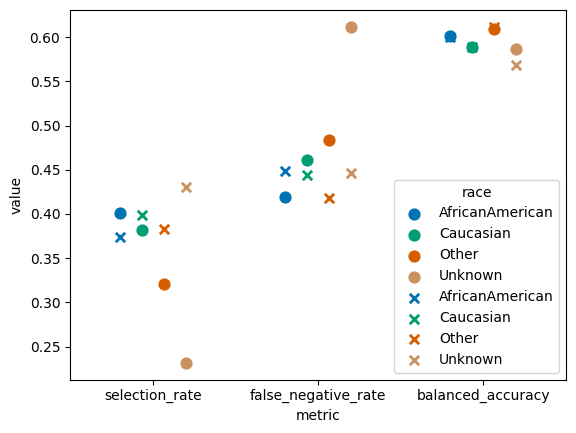

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.pointplot(data=df_long, x="metric", y="value", hue="race", palette=palette, linestyles="none",
              markers="o", dodge=0.4)
sns.pointplot(data=df_long_postprocess, x="metric", y="value", hue="race", palette=palette, linestyles="none",
              markers="x", dodge=0.4)
# bar = sns.pointplot(data=df_diff, x="metric", y="value", hue="race", palette=palette)


# ax.legend(title="Race")+
# ax.set_ylabel("Difference in Value")
# ax.set_xlabel("Metric")
# ax.set_xticklabels(labels=["Selection Rate", "False Negative Rate", "Balanced Accuracy"])

# plt.savefig("algorithmic_bias_difference.png", dpi=300, bbox_inches="tight")
# plt.show()


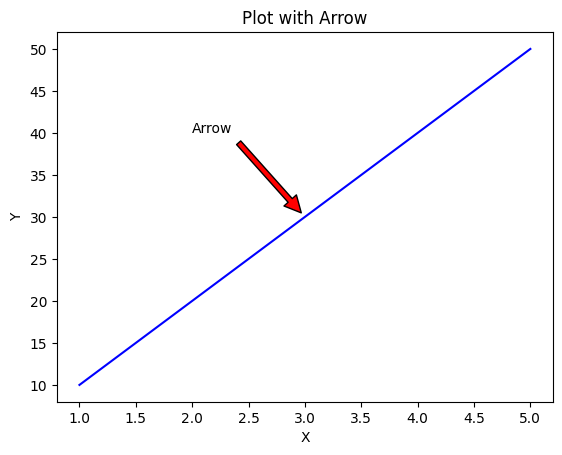

In [44]:
import matplotlib.pyplot as plt

# Example data for demonstration
x = [1, 2, 3, 4, 5]
y = [10, 20, 30, 40, 50]

# Plot the data
plt.plot(x, y, color='blue')

# Add an arrow at a specific point
plt.annotate('Arrow', xy=(3, 30), xytext=(2, 40),
             arrowprops=dict(facecolor='red', shrink=0.05))

# Customize labels and ticks
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Plot with Arrow')

plt.show()
